# **Importing modules**

In [14]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.layers import Conv2D, Dense, concatenate, LocallyConnected2D,multiply ,BatchNormalization,GlobalAveragePooling2D,Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, EarlyStopping
from tensorflow.keras.models import Model

Data Paths

In [16]:
train_path = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/train'
test_path = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/test'
val_path ='/kaggle/input/knee-osteoarthritis-dataset-with-severity/val'

In [17]:
list_of_classes = ['Healthy','Doubtful','Minimal','Moderate','Severe']

In [18]:
for d in [train_path, test_path, val_path]:
    filepaths = []
    labels=[] 
    classlist = os.listdir(d)
    for klass in classlist:
        intclass = int(klass)
        label = list_of_classes[intclass]
        classpath = os.path.join(d,klass)
        for item in os.listdir(classpath):
            imagepath = os.path.join(classpath,item)
            filepaths.append(imagepath)
            labels.append(label)
    df = pd.DataFrame(list(zip(filepaths, labels)),columns =['filepath', 'label'])
    if d  == train_path:
        train_df = df
    elif d == test_path:
        test_df = df
    else:
        val_df = df

In [19]:
train_df.to_csv('.train.csv')
test_df.to_csv('.test.csv')
val_df.to_csv('.val.csv')

# Dealing with Unbalanced Dataset

In [20]:
## Unbalanced dataset
print("Training images classwise images quantity")
for klass in ['0','1','2','3','4']:
    print(klass + ': ' + str(len(os.listdir(os.path.join(train_path,klass)))))

Training images classwise images quantity
0: 2286
1: 1046
2: 1516
3: 757
4: 173


In [21]:
train_df.groupby('label').get_group('Healthy').sample(10,random_state = 42,axis=0)

,filepath,label
3033,/kaggle/input/knee-osteoarthritis-dataset-with...,Healthy
2741,/kaggle/input/knee-osteoarthritis-dataset-with...,Healthy
3041,/kaggle/input/knee-osteoarthritis-dataset-with...,Healthy
2333,/kaggle/input/knee-osteoarthritis-dataset-with...,Healthy
3675,/kaggle/input/knee-osteoarthritis-dataset-with...,Healthy
2064,/kaggle/input/knee-osteoarthritis-dataset-with...,Healthy
2231,/kaggle/input/knee-osteoarthritis-dataset-with...,Healthy
3681,/kaggle/input/knee-osteoarthritis-dataset-with...,Healthy
3495,/kaggle/input/knee-osteoarthritis-dataset-with...,Healthy
3376,/kaggle/input/knee-osteoarthritis-dataset-with...,Healthy


***Trim the dataset to have at most 1000 images per class***

In [22]:
def trim(df, max_images, min_images,column):
    groups = df.groupby(column)
    trimmed_df = pd.DataFrame(columns = df.columns)
    for label in df[column].unique():
        grp = groups.get_group(label)
        count = len(grp)
        if count > max_images:
            selected_df = grp.sample(n=max_images,random_state =42,axis =0)
            trimmed_df = pd.concat([trimmed_df,selected_df],axis=0)
        else:
            if count >= min_images:
                selected_df = grp
                trimmed_df = pd.concat([trimmed_df,selected_df],axis=0)
    return trimmed_df
        
max_images = 1000
min_images = 173
train_trim_df = trim(train_df,max_images,min_images,'label')
train_trim_df

,filepath,label
51,/kaggle/input/knee-osteoarthritis-dataset-with...,Minimal
168,/kaggle/input/knee-osteoarthritis-dataset-with...,Minimal
1469,/kaggle/input/knee-osteoarthritis-dataset-with...,Minimal
926,/kaggle/input/knee-osteoarthritis-dataset-with...,Minimal
422,/kaggle/input/knee-osteoarthritis-dataset-with...,Minimal
...,...,...
5773,/kaggle/input/knee-osteoarthritis-dataset-with...,Severe
5774,/kaggle/input/knee-osteoarthritis-dataset-with...,Severe
5775,/kaggle/input/knee-osteoarthritis-dataset-with...,Severe
5776,/kaggle/input/knee-osteoarthritis-dataset-with...,Severe


In [23]:
# check
group = train_trim_df.groupby('label')
for label in df['label'].unique():
    grp = group.get_group(label)
    count = len(grp)
    print(label +': '+str(count))

Minimal: 1000
Healthy: 1000
Moderate: 757
Doubtful: 1000
Severe: 173


**Making all classes contain exactly 1000 images**

In [24]:
def balance(df,limit,work_dir):
    aug_dir = os.path.join(work_dir,'augmented')
    if not os.path.exists(aug_dir):
        os.mkdir(aug_dir)
    gen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.5,
        horizontal_flip=True,
        vertical_flip=True
    )
    total=0
    for label in df['label'].unique():
        label_dir = os.path.join(aug_dir,label)
        if not os.path.exists(label_dir):
            os.mkdir(label_dir)
        class_samples = df.groupby('label').get_group(label)
        count = len(class_samples)
        if count< limit:
            remain = limit - count
            image_gen= gen.flow_from_dataframe(class_samples,
                                             x_col='filepath', y_col='label',  
                                             target_size=(224,224), 
                                             color_mode='rgb', 
                                             classes=None,
                                             batch_size=1, 
                                             shuffle=True, 
                                             seed=None, save_to_dir=label_dir, 
                                             save_prefix='aug', save_format='jpg')
            image_aug_count =0
            for i in range(remain):
                aug = next(image_gen)
                image_aug_count +=len(aug)
            total += image_aug_count
    filepaths = []
    labels=[] 
    classlist = os.listdir(aug_dir)
    for klass in classlist:
        label = klass
        classpath = os.path.join(aug_dir,klass)
        for item in os.listdir(classpath):
            imagepath = os.path.join(classpath,item)
            filepaths.append(imagepath)
            labels.append(label)
    aug_df = pd.DataFrame(list(zip(filepaths, labels)),columns =['filepath', 'label'])
    aug_df = pd.concat([df,aug_df],axis=0).reset_index(drop=False)
    return aug_df

working_dir = './'
train_balance_df = balance(train_trim_df,1000,working_dir)

Found 757 validated image filenames belonging to 1 classes.
Found 173 validated image filenames belonging to 1 classes.


In [25]:
# check
group = train_balance_df.groupby('label')
for label in df['label'].unique():
    grp = group.get_group(label)
    count = len(grp)
    print(label +': '+str(count))

Minimal: 1000
Healthy: 1000
Moderate: 1000
Doubtful: 1000
Severe: 1000


# Train, Test, Validation generators

In [26]:
batch_size = 20

In [27]:
train_df = train_balance_df

In [28]:
train_df

,index,filepath,label
0,51,/kaggle/input/knee-osteoarthritis-dataset-with...,Minimal
1,168,/kaggle/input/knee-osteoarthritis-dataset-with...,Minimal
2,1469,/kaggle/input/knee-osteoarthritis-dataset-with...,Minimal
3,926,/kaggle/input/knee-osteoarthritis-dataset-with...,Minimal
4,422,/kaggle/input/knee-osteoarthritis-dataset-with...,Minimal
...,...,...,...
4995,1065,./augmented/Severe/aug_81_5675763.jpg,Severe
4996,1066,./augmented/Severe/aug_171_7534580.jpg,Severe
4997,1067,./augmented/Severe/aug_96_3717706.jpg,Severe
4998,1068,./augmented/Severe/aug_106_3346172.jpg,Severe


In [29]:
trgen = ImageDataGenerator(horizontal_flip=True,rotation_range = 0.2)
tst_valgen = ImageDataGenerator()
train_gen = trgen.flow_from_dataframe(train_df,
                                    x_col='filepath',
                                    y_col='label',
                                    target_size=(224,224),
                                    color_mode='rgb',
                                    class_mode='categorical',
                                    batch_size=batch_size,
                                    shuffle=True)

Found 5000 validated image filenames belonging to 5 classes.


In [30]:
val_gen = tst_valgen.flow_from_dataframe(val_df,
                                    x_col='filepath',
                                    y_col='label',
                                    target_size=(224,224),
                                    color_mode='rgb',
                                    class_mode='categorical',
                                    batch_size=batch_size,
                                    shuffle=False)

Found 826 validated image filenames belonging to 5 classes.


In [31]:
count = len(test_df)
count

1656

In [32]:
test_batch_size = max([int(count/n) for n in range(1,count+1) if count%n ==0  and count/n<=80])
test_batch_size

72

In [33]:
test_gen = tst_valgen.flow_from_dataframe(test_df,
                                    x_col='filepath',
                                    y_col='label',
                                    target_size=(224,224),
                                    color_mode='rgb',
                                    class_mode='categorical',
                                    batch_size=test_batch_size,
                                    shuffle=False)

Found 1656 validated image filenames belonging to 5 classes.


**showing some images**

In [34]:
classes = list(train_gen.class_indices.keys())
classes

['Doubtful', 'Healthy', 'Minimal', 'Moderate', 'Severe']

In [35]:
images,labels = next(train_gen)

In [36]:
num = len(images)
if num < 25:
    n = num
else:
    n = 25

In [37]:
plt.figure(figsize = (50,50))

<Figure size 3600x3600 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

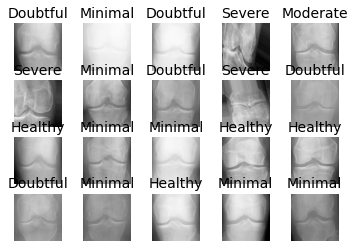

In [38]:
for i in range(n):
    plt.subplot(4,5,i+1)
    index = np.argmax(labels[i])
    label = classes[index]
    image = images[i]/255
    plt.imshow(image)
    plt.title(label,fontsize = 14)
    plt.axis('off')

# Model Creation

In [39]:
config ={
    'monitor': 'accuracy',
    'epochs' : 50,
    'batch_size' : 64,
    'lr' : 0.00001,
    'beta' : 0.9,
    'mode' : 'max',
    'factor': 0.1,
    'patience' : 2,
    'loss_weights': [1,0.8],
    'combine': 'early-fusion'
}

In [40]:
def attention_branch(layer,att_name):
    depth = layer.shape[-1]
    bn = BatchNormalization()(layer)
    x = Conv2D(filters=64, kernel_size=(1,1),activation='relu')(bn)
    x = Conv2D(filters=16, kernel_size=(1,1),activation='relu')(x)
    x= LocallyConnected2D(filters=1, kernel_size=(1,1),activation='sigmoid')(x)
    att = Conv2D(filters=depth, kernel_size=(1,1),activation='linear', padding='same',
                 use_bias=False, weights=[np.ones(shape=(1, 1, 1, depth))],name = att_name)(x)
    att.trainable = False
    mul = multiply([att,bn])
    feature = GlobalAveragePooling2D()(mul)
    mask = GlobalAveragePooling2D()(att)
    branch = Lambda(lambda i: i[0] / i[1])([feature, mask])
    return branch

In [41]:
def combine_single(branches):
    x = concatenate(branches) if len(branches)>1 else branches[0]
    return Dense(5,activation = 'softmax')(x)

In [42]:
def combine_multi(branches):
    return [Dense(5,activation ='softmax')(x) for x in branches]

In [43]:
def attention_model():
    input_shape = (224,224,3)
    arch = VGG16(input_shape=input_shape,include_top=False, weights='imagenet')
    attn_layers = ['block3_pool','block4_pool']
    branches =[]
    for index,layer in enumerate(attn_layers):
        branches.append(attention_branch(arch.get_layer(layer).output,'Att_%d' % index))
    if config['combine'] == 'multi-loss':
        output = combine_multi(branches)
    else:
        output = combine_single(branches)
    model = Model(inputs = arch.input, outputs = output)
    return model

In [44]:
def flow_multi_loss(generator,n):
    for x,y in generator:
        yield x,[y]*n

In [45]:
# log directory
# log_dir = os.path.join('/kaggle/working/','logs')
# if not os.path.exists(log_dir):
#     os.mkdir(log_dir)
#     os.mkdir(os.path.join(log_dir,'vgg-attention-logs'))
#     os.mkdir(os.path.join(log_dir,'resnet-logs'))
#     os.mkdir(os.path.join(log_dir,'efficientnet-logs'))

In [46]:
def train():
    model = attention_model()
    model_check_point = ModelCheckpoint('weights.{epoch:02d}-{accuracy:.2f}.hdf5',
                                        monitor=config['monitor'],
                                        verbose=1,
                                        mode=config['mode'],
                                        save_best_only=True,
                                        save_weights_only=True)
    
    reduce_lr = ReduceLROnPlateau(monitor=config['monitor'],
                                    factor=config['factor'],
                                    patience=config['patience'],
                                    verbose=0,
                                    mode=config['mode']) 
    attention_logs = '/kaggle/working/logs/vgg-attention-logs'
    tensorboard = TensorBoard(log_dir = attention_logs) 
    
    earlystop = EarlyStopping(monitor=config['monitor'],
                            patience=4,
                            verbose=0,
                            mode=config['mode'],
                            restore_best_weights=True)
    callbacklist = [model_check_point,reduce_lr,earlystop,tensorboard]
    if config['combine'] == 'multi-loss':
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = config['lr']),
                      loss = ['categorical_crossentropy']*2,
                      loss_weights = config['loss_weights'],
                      metrics = 'accuracy')
        model.fit(flow_multi_loss(train_gen,2),
                  validation_data = flow_multi_loss(val_gen,2),
                  steps_per_epoch = (train_gen.samples//config['batch_size'])*0.9,
                  epochs = config['epochs'],
                  validation_steps = val_gen.samples//config['batch_size'],
                  callbacks = callbacklist)
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = config['lr']),
                      loss = 'categorical_crossentropy',
                      metrics = 'accuracy')
        model.fit(train_gen,
                  validation_data = val_gen,
                  steps_per_epoch = train_gen.samples//config['batch_size'],
                  epochs = config['epochs'],
                  validation_steps = val_gen.samples//config['batch_size'],
                  callbacks = callbacklist)
    return model

In [47]:
model = train()

2022-12-07 16:14:17.672859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 16:14:17.673775: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 16:14:18.039114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 16:14:18.039985: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 16:14:18.040776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

58900480/58889256 [==============================] - 0s 0us/step


2022-12-07 16:14:26.567321: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-07 16:14:26.567366: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-07 16:14:26.571098: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs
2022-12-07 16:14:27.055988: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-07 16:14:27.056189: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-12-07 16:14:27.580623: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-12-07 16:14:55.229129: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/78 [..............................] - ETA: 57:10 - loss: 1.6806 - accuracy: 0.1000

2022-12-07 16:15:13.040239: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-07 16:15:13.040297: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/78 [..............................] - ETA: 2:30 - loss: 1.6538 - accuracy: 0.1250 

2022-12-07 16:15:14.179109: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-07 16:15:14.183405: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-07 16:15:14.392451: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 3532 callback api events and 3529 activity events. 
2022-12-07 16:15:14.528178: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-07 16:15:14.767044: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /kaggle/working/logs/vgg-attention-logs/train/plugins/profile/2022_12_07_16_15_14

2022-12-07 16:15:14.910682: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /kaggle/working/logs/vgg-attention-logs/train/plugins/profile/2022_12_07_16_15_14/87bcc81fae5c.trace.json.gz
2022-12-07 16:15:15.140310: I tensorflow/core/prof

78/78 [==============================] - 87s 555ms/step - loss: 1.4277 - accuracy: 0.3449 - val_loss: 0.7564 - val_accuracy: 0.8292

Epoch 00001: accuracy improved from -inf to 0.34487, saving model to weights.01-0.34.hdf5
Epoch 2/50
78/78 [==============================] - 31s 397ms/step - loss: 1.2839 - accuracy: 0.4385 - val_loss: 1.3856 - val_accuracy: 0.2333

Epoch 00002: accuracy improved from 0.34487 to 0.43846, saving model to weights.02-0.44.hdf5
Epoch 3/50
78/78 [==============================] - 30s 383ms/step - loss: 1.2107 - accuracy: 0.4718 - val_loss: 1.2431 - val_accuracy: 0.4750

Epoch 00003: accuracy improved from 0.43846 to 0.47179, saving model to weights.03-0.47.hdf5
Epoch 4/50
78/78 [==============================] - 32s 402ms/step - loss: 1.1629 - accuracy: 0.4981 - val_loss: 1.3999 - val_accuracy: 0.2375

Epoch 00004: accuracy improved from 0.47179 to 0.49808, saving model to weights.04-0.50.hdf5
Epoch 5/50
78/78 [==============================] - 30s 379ms/step

In [48]:
model.save('model4.h5')

In [49]:
scores = model.evaluate(test_gen,batch_size = 72)

23/23 [==============================] - 26s 647ms/step - loss: 0.8954 - accuracy: 0.6184


In [50]:
scores

[0.8953999876976013, 0.6183574795722961]

# **Comparing with Resnet50 and Efficientnet**

In [60]:
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout,Dense
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB5

In [52]:
resnet = ResNet50(include_top = False,weights = 'imagenet',input_shape = (224,224,3))
efficientnet = EfficientNetB5(include_top=False, weights="imagenet",input_shape=(224,224,3))

115277824/115263384 [==============================] - 1s 0us/step


**ResNet50**

In [53]:
res_output = resnet.layers[-1].output
res_output = tf.keras.layers.Flatten()(res_output)
resnet = Model(resnet.input, outputs=res_output)
for layer in resnet.layers:
    layer.trainable = False

In [61]:
resmodel = Sequential()
resmodel.add(resnet)
resmodel.add(Dense(512, activation='relu'))
resmodel.add(Dropout(0.3))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.3))
resmodel.add(Dense(5, activation='softmax'))
resmodel.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])
resmodel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 100352)            23587712  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 2565      
Total params: 74,971,013
Trainable params: 51,383,301
Non-trainable params: 23,587,712
_________________________________________________________________


In [62]:
reduce_lr = ReduceLROnPlateau(monitor=config['monitor'],
                                factor=config['factor'],
                                patience=config['patience'],
                                verbose=0,
                                mode=config['mode']) 
resnet_logs = '/kaggle/working/logs/resnet-logs'
tensorboard = TensorBoard(log_dir = resnet_logs)

earlystop = EarlyStopping(monitor=config['monitor'],
                        patience=4,
                        verbose=0,
                        mode=config['mode'],
                        restore_best_weights=True)
callbacklist = [reduce_lr,earlystop,tensorboard]
resmodel.fit(train_gen,
          validation_data = val_gen,
          steps_per_epoch = train_gen.samples//config['batch_size'],
          epochs = config['epochs'],
          validation_steps = val_gen.samples//config['batch_size'],
          callbacks = callbacklist)

2022-12-07 16:36:12.141903: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-07 16:36:12.141970: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-07 16:36:12.586172: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-07 16:36:12.586442: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/50
 1/78 [..............................] - ETA: 4:39 - loss: 2.3634 - accuracy: 0.4000

2022-12-07 16:36:17.013829: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-07 16:36:17.013873: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/78 [..............................] - ETA: 44s - loss: 660.4431 - accuracy: 0.2500

2022-12-07 16:36:18.210348: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-07 16:36:18.211507: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-07 16:36:18.387899: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 383 callback api events and 380 activity events. 
2022-12-07 16:36:18.401974: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 3/78 [>.............................] - ETA: 1:00 - loss: 1100.9664 - accuracy: 0.2333

2022-12-07 16:36:18.416599: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /kaggle/working/logs/resnet-logs/train/plugins/profile/2022_12_07_16_36_18

2022-12-07 16:36:18.424131: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /kaggle/working/logs/resnet-logs/train/plugins/profile/2022_12_07_16_36_18/87bcc81fae5c.trace.json.gz
2022-12-07 16:36:18.461142: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /kaggle/working/logs/resnet-logs/train/plugins/profile/2022_12_07_16_36_18

2022-12-07 16:36:18.467643: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to /kaggle/working/logs/resnet-logs/train/plugins/profile/2022_12_07_16_36_18/87bcc81fae5c.memory_profile.json.gz
2022-12-07 16:36:18.469038: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: /kaggle/working/logs/resnet-logs/tra

78/78 [==============================] - 27s 305ms/step - loss: 119.2545 - accuracy: 0.3058 - val_loss: 1.5347 - val_accuracy: 0.8917
Epoch 2/50
78/78 [==============================] - 22s 280ms/step - loss: 1.8636 - accuracy: 0.3308 - val_loss: 1.4070 - val_accuracy: 0.8917
Epoch 3/50
78/78 [==============================] - 22s 278ms/step - loss: 2.1016 - accuracy: 0.3186 - val_loss: 1.3977 - val_accuracy: 0.8708
Epoch 4/50
78/78 [==============================] - 21s 267ms/step - loss: 2.0271 - accuracy: 0.3051 - val_loss: 1.4299 - val_accuracy: 0.0042
Epoch 5/50
78/78 [==============================] - 22s 277ms/step - loss: 1.7707 - accuracy: 0.2686 - val_loss: 1.4327 - val_accuracy: 0.0042
Epoch 6/50
78/78 [==============================] - 22s 276ms/step - loss: 1.5794 - accuracy: 0.2910 - val_loss: 1.4319 - val_accuracy: 0.8833


In [69]:
resnet_scores = resmodel.evaluate(test_gen,batch_size = 72)

23/23 [==============================] - 8s 296ms/step - loss: 1.5507 - accuracy: 0.2736


**EfficientNet**

In [64]:
eff_output = efficientnet.layers[-1].output
eff_output = tf.keras.layers.Flatten()(eff_output)
efficientnet = Model(efficientnet.input, outputs=eff_output)
for layer in efficientnet.layers:
    layer.trainable = False

In [65]:
effmodel = Sequential()
effmodel.add(efficientnet)
effmodel.add(Dense(512, activation='relu'))
effmodel.add(Dropout(0.3))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.3))
effmodel.add(Dense(5, activation='softmax'))
effmodel.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])
effmodel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 100352)            28513527  
_________________________________________________________________
dense_6 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 2565      
Total params: 79,896,828
Trainable params: 51,383,301
Non-trainable params: 28,513,527
_________________________________________________________________


In [66]:
reduce_lr = ReduceLROnPlateau(monitor=config['monitor'],
                                factor=config['factor'],
                                patience=config['patience'],
                                verbose=0,
                                mode=config['mode']) 

efflogs = '/kaggle/working/logs/efficientnet-logs'
tensorboard = TensorBoard(log_dir = efflogs) 

earlystop = EarlyStopping(monitor=config['monitor'],
                        patience=4,
                        verbose=0,
                        mode=config['mode'],
                        restore_best_weights=True)
callbacklist = [reduce_lr,earlystop,tensorboard]
effmodel.fit(train_gen,
          validation_data = val_gen,
          steps_per_epoch = train_gen.samples//config['batch_size'],
          epochs = config['epochs'],
          validation_steps = val_gen.samples//config['batch_size'],
          callbacks = callbacklist)

2022-12-07 16:48:31.798844: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-07 16:48:31.798917: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-07 16:48:32.264782: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-07 16:48:32.265014: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Epoch 1/50
 1/78 [..............................] - ETA: 18:50 - loss: 2.0637 - accuracy: 0.2000

2022-12-07 16:48:48.317173: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-07 16:48:48.317227: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/78 [..............................] - ETA: 1:30 - loss: 214.6932 - accuracy: 0.2500

2022-12-07 16:48:49.482108: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-07 16:48:49.485681: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-07 16:48:49.669718: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 1335 callback api events and 1332 activity events. 
2022-12-07 16:48:49.707966: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-07 16:48:49.751862: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /kaggle/working/logs/efficientnet-logs/train/plugins/profile/2022_12_07_16_48_49

2022-12-07 16:48:49.777958: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /kaggle/working/logs/efficientnet-logs/train/plugins/profile/2022_12_07_16_48_49/87bcc81fae5c.trace.json.gz
2022-12-07 16:48:49.842396: I tensorflow/core/profil

78/78 [==============================] - 45s 392ms/step - loss: 113.0291 - accuracy: 0.3224 - val_loss: 1.6048 - val_accuracy: 0.8708
Epoch 2/50
78/78 [==============================] - 26s 329ms/step - loss: 1.7750 - accuracy: 0.3173 - val_loss: 1.4371 - val_accuracy: 0.8792
Epoch 3/50
78/78 [==============================] - 25s 325ms/step - loss: 2.3354 - accuracy: 0.3212 - val_loss: 1.4757 - val_accuracy: 0.1167
Epoch 4/50
78/78 [==============================] - 25s 320ms/step - loss: 2.1660 - accuracy: 0.3468 - val_loss: 1.4495 - val_accuracy: 0.1125
Epoch 5/50
78/78 [==============================] - 25s 326ms/step - loss: 1.4701 - accuracy: 0.3231 - val_loss: 1.4446 - val_accuracy: 0.1167
Epoch 6/50
78/78 [==============================] - 25s 315ms/step - loss: 1.4188 - accuracy: 0.3442 - val_loss: 1.4425 - val_accuracy: 0.1167
Epoch 7/50
78/78 [==============================] - 26s 335ms/step - loss: 1.3717 - accuracy: 0.3628 - val_loss: 1.4424 - val_accuracy: 0.1167
Epoch 8/

In [68]:
scores = effmodel.evaluate(test_gen,batch_size = 72)

23/23 [==============================] - 10s 445ms/step - loss: 1.5580 - accuracy: 0.3901


In [70]:
import shutil

In [76]:
shutil.make_archive('logs', 'zip','/kaggle/working/logs')

'/kaggle/working/logs.zip'

In [7]:
%reload_ext tensorboard
%tensorboard --logdir={'logs'}

Reusing TensorBoard on port 6006 (pid 2152), started 7:57:29 ago. (Use '!kill 2152' to kill it.)